## Simulation of the expression of a single Gaussian Process Neuron and its interpretation

Consider the following random variable $y$:
$$
    y=\int fp(x)dx, \quad f\sim\mathcal{GP}(m(\cdot), k(\cdot, \cdot))
$$
where
$$
\begin{aligned}
    m(x)&=0 \\
    k(x,x')&=s^2 \exp(-\frac{(x-x')^2}{2l^2})=\sqrt{2\pi}s^2l\mathcal{N}(x|x',l^2) \\
    p(x)&=\mathcal{N}(x|\mu_x,\sigma_x^2)
\end{aligned}
$$
Then the expression for $y$ is as follows:
\begin{equation*}
\begin{aligned}
    y&\sim\mathcal{N}(\mu_y, \sigma_y^2) \\
    \mu_y&=\sqrt{2\pi}s^2l\boldsymbol{q}_{xh}(K_{hh}+\sigma_n^2 I)^{-1}\boldsymbol{h} \\
    \sigma_y^2&=\frac{s^2l}{\sqrt{l^2+2\sigma_x^2}} - 2\pi s^4 l^2 \boldsymbol{q}_{xh}(K_{hh}+\sigma_n^2 I)^{-1}\boldsymbol{q}_{hx} \\
    \text{where }\boldsymbol{q}_{xh}^T&=\boldsymbol{q}_{hx}=\begin{bmatrix}
        \mathcal{N}(z_1|\mu_x,\sigma_x^2+l^2) \\
        \mathcal{N}(z_2|\mu_x,\sigma_x^2+l^2) \\
        \vdots
    \end{bmatrix}
\end{aligned}
\tag{1}
\end{equation*}

This expression for $y$ can be interpreted as the following steps:
1. Draw $\boldsymbol{x}=[x_1\space x_2\space ... \space x_n]^T$ from $x_i\sim \mathcal{N}(\mu_x,\sigma_x^2)$
2. Compute the predictive posterior $p(\boldsymbol{f}|\boldsymbol{h},\boldsymbol{z})$ at locations $\boldsymbol{x}$, for $f\sim\mathcal{GP}(m(\cdot),k(\cdot,\cdot))$, ie. 
$$
\begin{aligned}
    p(\boldsymbol{f}|\boldsymbol{h},\boldsymbol{z})&=\mathcal{N}(\mu_f,\Sigma_f) \\
    \mu_f&=K_{fh}(K_{hh} + \sigma_n^2I)^{-1}\boldsymbol{h} \\
    \Sigma_f&=K_{ff} - K_{fh}(K_{hh} + \sigma_n^2I)^{-1}K_{hf}
\end{aligned}
$$
3. Draw a sample $\boldsymbol{f}\sim p(\boldsymbol{f}|\boldsymbol{h},\boldsymbol{z})$ and take $y=\frac{1}{n}\sum_{i=1}^{n}f_i$

The following code will simulate the steps above to verify the analytical results

In [1]:
import numpy as np

# Define a distribution for x
x_mean = 0
x_var = 1   # square of std_dev
N = 500     # set sample size

# Define some known GP points
N_known = 10                                            # set size of known GP points
h = np.random.rand(N_known)
z = np.random.normal(x_mean, x_var**0.5, N_known)   # known locations should be in the same region as the sample x

# Define label noise
sigma_n = 0.01

# Define the squared exponential covariance function
s = 1     # signal strength
l = 0.5   # lengthscale
def se_covar(z1, z2):
    return s**2 * np.exp(-(z1-z2)**2 / (2 * l**2))

# Define a utility function to obtain the covariance matrix
def k_matrix(z1, z2, covar_func):
    """a, b are 1-D vectors, and covar_func should be broadcastable"""
    assert len(z1.shape) == 1
    assert len(z2.shape) == 1
    N1 = z1.shape[0]
    N2 = z2.shape[0]
    z1_repeat = np.tile(z1, N2).reshape(N2, N1).T.reshape(N1 * N2)
    z2_repeat = np.tile(z2, N1)
    k_matrix = covar_func(z1_repeat, z2_repeat)
    return k_matrix.reshape(N1, N2)

Next, set up the GP posterior distribution and get samples of y. Note that this step's computational complexity grows $\mathcal{O}(N^3)$ to sample size $N$, so it might take some time to run

In [2]:
K_hh = k_matrix(z, z, se_covar)
K_hh_noise = K_hh + sigma_n**2 * np.eye(K_hh.shape[0])

# invert using cholesky decomposition for numerical stability
L = np.linalg.cholesky(K_hh_noise)
L_inv = np.linalg.inv(L)
K_hh_noise_inv = L_inv.T @ L_inv

y_samples = []
for _ in range(100):
    # draw a sample of x
    x = np.random.normal(x_mean, x_var**0.5, N) 

    # compute the covariance matrices
    K_fh = k_matrix(x, z, se_covar)
    K_ff = k_matrix(x, x, se_covar)
    
    # GP posterior mean
    mu_f = K_fh @ K_hh_noise_inv @ h.reshape(-1, 1)
    # GP posterior var
    A = K_fh @ L_inv.T
    var_f = K_ff - A @ A.T

    # get a sample of f, and compute y
    f = np.random.multivariate_normal(mu_f.reshape(-1), var_f)
    y = np.mean(f)
    y_samples.append(y)

Next, compute analytically the mean and var of $y$ using Equation 1, and compare it with the empirical mean, var

In [3]:
def normal_pdf(val, mean, var):
    return (1 / np.sqrt(2 * np.pi * var)) * np.exp(-0.5 * ((val - mean) ** 2) / var)
    
q_func = lambda val, mean: normal_pdf(val, mean, x_var + l**2)
q_xh = k_matrix(np.array([x_mean]), z, q_func)

mu_y = np.sqrt(2 * np.pi) * s**2 * l * q_xh @ K_hh_noise_inv @ h.reshape(-1, 1)
var_y = (s**2 * l) / np.sqrt(l**2 + 2 * x_var) - 2 * np.pi * s**4 * l**2 * q_xh @ K_hh_noise_inv @ q_xh.T

print("analytical mean", mu_y.item())
print("analytical var ", var_y.item())
print("empirical mean ", np.mean(y_samples))
print("empirical var  ", np.var(y_samples))

analytical mean 0.3062615415340534
analytical var  0.0004325050380444284
empirical mean  0.30606778349236735
empirical var   0.0006015052365239453


Repeat this run for different values of $\mu_x,\sigma_x^2$ and GP known points $\boldsymbol{h},\boldsymbol{z}$ and plot the results

In [4]:
def run(_x_mean, _x_var):
    """wrap a full run into a function returning the analytical and empirical y_mean, y_var"""
    _h = np.random.rand(N_known)
    _z = np.random.normal(_x_mean, _x_var**0.5, N_known) # known locations should be in the same region as the sample x

    _K_hh = k_matrix(_z, _z, se_covar)
    _K_hh_noise = _K_hh + sigma_n**2 * np.eye(_K_hh.shape[0])

    # invert using cholesky decomposition for numerical stability
    _L = np.linalg.cholesky(_K_hh_noise)
    _L_inv = np.linalg.inv(_L)
    _K_hh_noise_inv = _L_inv.T @ _L_inv

    _y_samples = []
    for _ in range(100):
        # draw a sample of x
        _x = np.random.normal(_x_mean, _x_var**0.5, N) 
        # compute the covariance matrices
        _K_fh = k_matrix(_x, _z, se_covar)
        _K_ff = k_matrix(_x, _x, se_covar)
        # GP posterior mean
        _mu_f = _K_fh @ _K_hh_noise_inv @ _h.reshape(-1, 1)
        # GP posterior var
        _A = _K_fh @ _L_inv.T
        _var_f = _K_ff - _A @ _A.T
        # get a sample of f, and compute y
        _f = np.random.multivariate_normal(_mu_f.reshape(-1), _var_f)
        _y = np.mean(_f)
        _y_samples.append(_y)
    
    y_mean_emp = np.mean(_y_samples)
    y_var_emp = np.var(_y_samples)

    # analytical expr
    _q_func = lambda val, mean: normal_pdf(val, mean, _x_var + l**2)
    _q_xh = k_matrix(np.array([_x_mean]), _z, _q_func)
    y_mean_anl = np.sqrt(2 * np.pi) * s**2 * l * _q_xh @ _K_hh_noise_inv @ _h.reshape(-1, 1)
    y_var_anl = (s**2 * l) / np.sqrt(l**2 + 2 * _x_var) - 2 * np.pi * s**4 * l**2 * _q_xh @ _K_hh_noise_inv @ _q_xh.T

    return y_mean_emp, y_var_emp, y_mean_anl.item(), y_var_anl.item()


# repeat for different x_means, x_vars
y_mean_emps = []
y_var_emps = []
y_mean_anls = []
y_var_anls = []
import tqdm # for progress bar

for _ in tqdm.tqdm(range(30)):
    x_mean_sample = np.random.rand() * 6 - 3 # [-3, 3]
    x_var_sample = np.random.rand() * 3 + 1     # [1, 4]

    result = run(x_mean_sample, x_var_sample)
    y_mean_emps.append(result[0])
    y_var_emps.append(result[1])
    y_mean_anls.append(result[2])
    y_var_anls.append(result[3])



  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [02:18<00:00,  4.60s/it]


Plot the run graphs

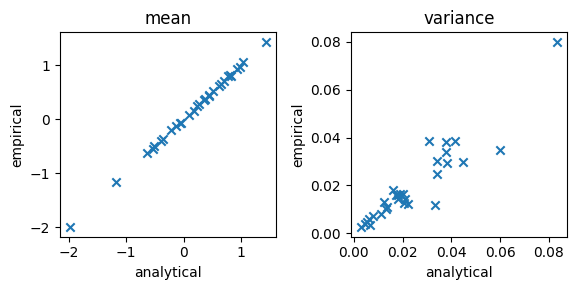

In [26]:
import matplotlib.pyplot as plt

fig, (ax_mean, ax_var) = plt.subplots(1, 2)

ax_mean.scatter(y_mean_emps, y_mean_anls, marker="x")
ax_mean.set_title("mean")
ax_mean.set_ylabel("empirical")
ax_mean.set_xlabel("analytical")

ax_var.scatter(y_var_emps, y_var_anls, marker="x")
ax_var.set_title("variance")
ax_var.set_ylabel("empirical")
ax_var.set_xlabel("analytical")

fig.set_figwidth(6)
fig.set_figheight(3)
fig.tight_layout()